 Extracted test dataset to: /content/ocrtest2
 Using image base folder: /content/ocrtest2/ocrtest2
 Models loaded successfully!


100%|██████████| 48/48 [00:02<00:00, 16.39it/s]


Loaded 235 test images across 47 EMNIST classes.

 Evaluating Model 1 (CNN)...
 Model 1 (CNN) Accuracy: 84.68%

 Evaluating Model 2 (CNN-LSTM)...
 Model 2 (CNN-LSTM) Accuracy: 85.11%


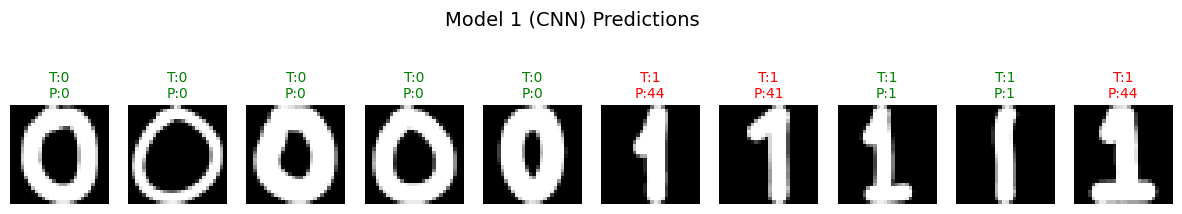

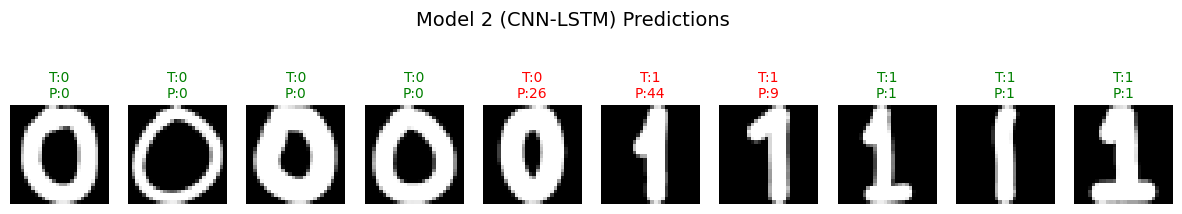

Results saved to eval_results_ocrtest2.npz

 Evaluation completed successfully!


In [4]:

#  SETUP

import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder



zip_path = "/content/ocrtest2.zip"
extract_path = "/content/ocrtest2"

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f" Extracted test dataset to: {extract_path}")

# Detect correct folder level
if os.path.isdir(os.path.join(extract_path, "ocrtest2")):
    BASE_DIR = os.path.join(extract_path, "ocrtest2")
else:
    BASE_DIR = extract_path

print(f" Using image base folder: {BASE_DIR}")


cnn_model = load_model("/content/cnn_model.keras")
lstm_model = load_model("/content/newhybrid2.keras")
print(" Models loaded successfully!")


def preprocess_emnist_style(img_path):
    """Convert image to EMNIST-compatible format (invert, center, normalize)"""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    #  Invert colors (make white text on black background)
    img = cv2.bitwise_not(img)

    # Threshold to binary for contour detection
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #  Find character bounding box and crop
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        char = img[y:y+h, x:x+w]
    else:
        char = img
        w, h = img.shape[1], img.shape[0]

    #  Center on square canvas
    side = max(w, h)
    square = np.zeros((side, side), dtype=np.uint8)
    x_offset = (side - w) // 2
    y_offset = (side - h) // 2
    square[y_offset:y_offset+h, x_offset:x_offset+w] = char

    #  Resize to 28×28
    resized = cv2.resize(square, (28, 28), interpolation=cv2.INTER_AREA)

    #  Normalize to 0-1
    resized = resized.astype("float32") / 255.0

    #  Add channel dimension
    return np.expand_dims(resized, axis=-1)


def load_custom_dataset_emnist_style(base_dir):
    X, y = [], []
    for label in tqdm(sorted(os.listdir(base_dir))):
        if not label.isdigit():
            continue
        label_idx = int(label)
        folder = os.path.join(base_dir, label)
        if not os.path.isdir(folder):
            continue
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder, fname)
                img = preprocess_emnist_style(img_path)
                if img is not None:
                    X.append(img)
                    y.append(label_idx)
    return np.array(X), np.array(y)

X_test, y_test = load_custom_dataset_emnist_style(BASE_DIR)
print(f"Loaded {len(X_test)} test images across {len(set(y_test))} EMNIST classes.")


encoder = LabelEncoder()
encoder.fit(sorted(list(set(y_test))))
y_test_encoded = encoder.transform(y_test)


def evaluate_model(model, X, y_true, name):
    if len(X) == 0:
        print(f" No images to evaluate for {name}.")
        return None, 0.0
    y_pred = np.argmax(model.predict(X, verbose=0), axis=1)
    acc = np.mean(y_pred == y_true) * 100
    print(f" {name} Accuracy: {acc:.2f}%")
    return y_pred, acc

print("\n Evaluating Model 1 (CNN)...")
y_pred1, acc1 = evaluate_model(cnn_model, X_test, y_test_encoded, "Model 1 (CNN)")

print("\n Evaluating Model 2 (CNN-LSTM)...")
y_pred2, acc2 = evaluate_model(lstm_model, X_test, y_test_encoded, "Model 2 (CNN-LSTM)")


def show_predictions(X, y_true, y_pred, title, n=10):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=14)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.axis('off')
        color = "green" if y_true[i] == y_pred[i] else "red"
        plt.title(f"T:{y_true[i]}\nP:{y_pred[i]}", color=color, fontsize=10)
    plt.show()

show_predictions(X_test, y_test_encoded, y_pred1, "Model 1 (CNN) Predictions")
show_predictions(X_test, y_test_encoded, y_pred2, "Model 2 (CNN-LSTM) Predictions")


np.savez("/content/eval_results_ocrtest2.npz",
         y_true=y_test_encoded,
         y_pred_cnn=y_pred1,
         y_pred_lstm=y_pred2)
print("Results saved to eval_results_ocrtest2.npz")

print("\n Evaluation completed successfully!")
